In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import sklearn
import os
import os
import numpy as np
import concurrent.futures
from skimage.feature import hog
from skimage import exposure
from skimage.feature import local_binary_pattern
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from PIL import Image
import sys


os.environ['MOMAPS_HOME'] = '/home/labs/hornsteinlab/Collaboration/MOmaps'

sys.path.insert(1, os.getenv('MOMAPS_HOME'))
sys.path.insert(1, os.getenv("MOMAPS_HOME"))
print(f"MOMAPS_HOME: {os.getenv('MOMAPS_HOME')}")

from src.common.lib import image_metrics
from src.common.lib.preprocessing_utils import rescale_intensity, handle_img_shape

%reload_ext autoreload
%autoreload 2
%aimport

%matplotlib inline

MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps
Modules to reload:
all-except-skipped

Modules to skip:



# Utils

In [2]:
# Load images
def get_npy_files(path):
    npy_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.npy'):
                npy_files.append(os.path.join(root, file))
    return npy_files

import skimage 

def get_metrics_processed(tile):
  metrics = ()
  for c in range(tile.shape[-1]):
    metrics += get_metrics(tile[...,c])
    
  return metrics

def get_metrics(tile, as_string=False):
    sharpness_brenner = image_metrics.calculate_image_sharpness_brenner(tile)    
    if as_string:
        return f"Brenner: {round(sharpness_brenner, 3)}"
    return sharpness_brenner

    snr = image_metrics.calculate_snr(tile)
    # Check contrast & Sharpness
    sharpness_laplacian = image_metrics.calculate_image_sharpness_laplacian(tile)
    # contrast = image_metrics.calculate_image_contrast(tile)
    # Check var
    var = image_metrics.calculate_var(tile)
    # Check blurness:
    # sharpness_brenner = image_metrics.calculate_image_sharpness_brenner(tile)    
    entropy = image_metrics.calculate_entropy(tile)
    sigma = image_metrics.calculate_sigma(tile)
    high_freq = image_metrics.calculate_high_freq_power(tile)
    # largest_area = calculate_largest_uniform_area(tile)
    # fractal_dim = calculate_fractal_dim(tile)
    # blur = image_metrics.calc_image_blur_effect(tile)
  
    if as_string:
          return f"SNR: {round(snr, 3)}, Sharpness Laplacian: {round(sharpness_laplacian, 3)}, Sharpness Brenner: {round(sharpness_brenner, 3)}, Variance: {var}, Entropy: {round(entropy, 3)}, Sigma: {round(sigma, 3)}, FFT freq: {round(high_freq, 3)}" 
  
    return snr,sharpness_laplacian,var,sharpness_brenner, entropy, sigma,high_freq #,largest_area
  

# def get_metrics_columns():
#   return ["Path", "Quality", "Target_SNR", "Target_Sharpness_Laplacian", "Target_Var",
#            'Target_Sharpness_Brenner', "Target_Entropy", "Target_Sigma", "Target_HighFreq", "DAPI_SNR", "DAPI_Sharpness_Laplacian",
#             "DAPI_Var", 'DAPI_Sharpness_Brenner', "DAPI_Entropy", "DAPI_Sigma", "DAPI_HighFreq"]


def run_dim_reduction(dim_red, images, labels=None, show=True):
  # Perform PCA
  images = images.reshape(images.shape[0], -1)
  reduced = dim_red.fit_transform(images)
  
  if not show:
    return reduced
  
  if labels is None:
    plt.scatter(reduced[:,0], reduced[:,1])
    plt.show()
    return reduced
  
  
  labels_unique = np.unique(labels)
  
  for l in labels_unique:
    indexes = labels == l
    plt.scatter(reduced[indexes,0], reduced[indexes,1], alpha=0.5)
  plt.legend(labels_unique)
  plt.show()
  
  return reduced 

def plot_images(images, vmin=0,vmax=1000):
    for i in range(len(images)):
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(images[i,...,0])#, vmin=vmin,vmax=vmax)
        ax[0].set_title("Target")
        ax[1].imshow(images[i,...,1])#, vmin=vmin,vmax=vmax)
        ax[1].set_title("Nucleus")
        plt.show()
        
def load_tiles(paths):
  paths_split = map(lambda x: (x.rsplit('_',1)[0], int(x.rsplit('_',1)[1])), paths.reshape(-1,))
  tiles = []
  for filename, tile_number in paths_split:
    t = np.load(filename)[tile_number, ...]
    tiles.append(t)
    
  tiles = np.stack(tiles)
  return tiles



def get_outliers(df, feature, split=False, iqrs=1.5):
    # Calculate Q1, Q3, and IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = df[feature] < Q1 - iqrs* IQR
    higher = df[feature] > Q3 + iqrs*IQR
    if split:
        # Determine outliers using IQR
        outliers_lower = df[lower]
        outliers_higher = df[higher]
        return outliers_lower, outliers_higher
    
    # Determine outliers using IQR
    outliers = df[(lower ) | (higher)]
    
    return outliers

def show_images(df, max_samples = 10):
    for ind, path in enumerate(df.Path.values):
        print(ind)
        if max_samples is not None and ind >= max_samples:
            print(f"Stopping at {ind}. There are {len(df.Path.values)} images in total")
            break
        
        # Target
        target_path = os.path.join(d, path)
        show_processed_tif(target_path)
        # His DAPI
        # path_l = target_path.split("/")
        # path_l[-2] = 'DAPI'
        
        # file_name = path_l[-1].split("_")
        # dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
        # dapi_file_name = "/".join([*path_l[:-1], dapi_file_name])
        # print(dapi_file_name)

        # show_processed_tif(dapi_file_name)
        print('--------------------------------')
        
def get_dapi_file_name(path):
    site_path, tile_number = path.rsplit('_',1)
    path_l = site_path.split("/")
    path_l[-2] = 'DAPI'

    file_name = path_l[-1].split("_")
    dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
    dapi_file_name = "/".join([*path_l[:-1], f'{dapi_file_name}_{tile_number}'])
    
    return dapi_file_name
        
def show_tiles(df, max_samples=10, rescale_tile=False):
    for ind, path in enumerate(df.Path.values):
        site_path, tile_number = path.rsplit('_',1)
        tile_number = int(tile_number)
        print(ind)
        if max_samples is not None and ind >= max_samples:
            print(f"Stopping at {ind}. There are {len(df.Path.values)} images in total")
            break
        
        # Target
        show_tile(site_path, tile_number, rescale_tile)
        # His DAPI
        path_l = site_path.split("/")
        path_l[-2] = 'DAPI'
        
        file_name = path_l[-1].split("_")
        dapi_file_name = "_".join([file_name[0], 'w1confDAPI', file_name[-1]])
        dapi_file_name = "/".join([*path_l[:-1], dapi_file_name])
        print(dapi_file_name)

        show_tile(dapi_file_name, tile_number, rescale_tile)
        print('--------------------------------')
        
def save_to_mapping(mappings, marker, metric_name, low_threshold, high_threshold):
    mappings[marker] = {
        metric_name: {
            'low_threshold': low_threshold,
            'high_threshold': high_threshold
        }
    }
    
def processed_path_to_raw_paths(path):
    path_splited = path.split(os.sep)
    filename = path_splited[-1]
    filename_split = filename.split('_')
    rep = filename_split[0]
    panel = filename_split[4]
    line = filename_split[5]
    filename_new = '_'.join(filename_split[1:4])
    batch = path_splited[-5]
    batch = batch.split('_')[0]
    cond = path_splited[-3]
    marker = path_splited[-2]
    
    ret = os.path.join("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk", batch, line, panel, cond, rep, marker, f'{filename_new}.tif')
    return ret

def raw_path_to_processed_path(path):
    path_splited = path.split(os.sep)
    filename = os.path.splitext(path_splited[-1])[0]
    rep = path_splited[-3]
    panel = path_splited[-5]
    line = path_splited[-6]
    batch = path_splited[-7]
    batch = f"{batch}_16bit_no_downsample"
    cond = path_splited[-4]
    marker = path_splited[-2]
    
    ret = os.path.join("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/", batch, line, cond, marker, f'{rep}_{filename}_{panel}_{line}_processed.npy')
    return ret


d = '/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/'

def show_label(path):
    path_l = path.split("/")
    return path_l[-7:]
    
def show_processed_tif(path):
    # read the image stack
    img = cv2.imread(path, cv2.IMREAD_ANYDEPTH) 
    img = handle_img_shape(img, 1024, 1024)
    # rescale pixel intensities
    img = rescale_intensity(img)
    
    # show the image with grid 
    fig, ax = plt.subplots(figsize=(7,7))
    plt.imshow(img, cmap='gray')
    put_tiles_grid(image=img, ax=ax)
    plt.axis('off')
    plt.title(show_label(path), color='purple')
    print(get_metrics(img, True))
    plt.show()
    
def show_tile(site_path, tile_number, rescale_tile=False):
    # read the image stack
    img = cv2.imread(site_path, cv2.IMREAD_ANYDEPTH) 
    img = handle_img_shape(img, 1024, 1024)
    # rescale pixel intensities
    img = rescale_intensity(img)
    
    row_ind = tile_number // 10
    col_ind = tile_number % 10
    img = img[row_ind * 100 : (row_ind + 1) * 100, col_ind * 100 : (col_ind + 1) * 100]
    
    print(f"img shape: {np.asarray(img).shape}")
    
#     # Check dead cells?
#     img_uint8 = img.astype(np.uint8)
#     # Apply Gaussian blur
# #     gray_blurred = cv2.GaussianBlur(img_uint8, (9, 9), 0)

#     # Apply Hough Circle Transform
#     # Adjust the parameters, especially minRadius and maxRadius, to detect small circles
#     circles = cv2.HoughCircles(img_uint8, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)
   
    
    if rescale_tile:
        print("NOTICE! Rescaling also the tile!!!!!")
        img = rescale_intensity(img)
    
    fig, ax = plt.subplots(figsize=(7,7))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    
#     if circles is not None:
#         print(f"circles count: {len(circles)}")
#         circles = np.uint16(np.around(circles))
#         for i in circles[0, :]:
#             center = (i[0], i[1])  # circle center
#             radius = i[2]  # circle radius
#             cv2.circle(image, center, radius, (0, 255, 0), 2)
    
#     put_tiles_grid(image=img, ax=ax)
    plt.axis('off')
    plt.title(show_label(site_path), color='purple')
    print(get_metrics(img, True))
    plt.show()
    
def crop_frame(original_image):
    # Crop the image by removing a 12-pixel frame from each side
    cropped_image = original_image[12:1012, 12:1012]  
    return cropped_image

def crop_site_to_tiles(img):
    from skimage.util import view_as_blocks
    # Break the cropped image into 64 tiles of size 100x100
    tile_size = 100
    num_tiles = 64

    # Reshape the image into tiles using view_as_blocks from skimage
    tiles = view_as_blocks(img, block_shape=(tile_size, tile_size, 3))

    for i in range(8):
        for j in range(8):
            tile = tiles[i, j]
    return 

def put_tiles_grid(image, ax):
    # assumes 1000x1000 image
    import matplotlib.patches as patches

    # Add dashed grid lines for 64 blocks
    num_blocks = 10
    block_size = 100

    for i in range(1, num_blocks):
        # Draw horizontal dashed lines
        ax.plot([0, 1000], [i * block_size, i * block_size], linestyle='--', lw=1, alpha=0.5, color='pink')

        # Draw vertical dashed lines
        ax.plot([i * block_size, i * block_size], [0, 1000], linestyle='--', lw=1, alpha=0.5, color='pink')

    # Remove x and y axis labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a title
    plt.title('Image with Dashed Grid of 64 Blocks')

    
    


# Main

In [3]:
# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/outliers_detection/raw_metrics_all_batches_all_metrics_site_fix.csv")
# df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/sandbox/outliers_detection/raw_metrics_all_batches_brenner_site_dNLS.csv")
df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/sandbox/outliers_detection/brenner_values/raw_metrics_fus_fixed200224_2.csv")
df

Path  \
0       /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
1       /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
2       /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
3       /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
4       /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
...                                                   ...   
190395  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
190396  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
190397  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
190398  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
190399  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   

                                               RootFolder Marker  Condition  \
0       /home/labs/hornsteinlab/Collaboration/MOmaps/i...   CLTC       BMAA   
1       /home/labs/hornsteinlab/Collaboration/MOmaps/i...   CLTC       BMAA   
2       /home/labs/hornsteinlab/Collaboration/MOmaps/i...   CLTC       BMAA   
3       /home/labs/hornsteinlab/Collaboration/MOmaps/i...   CLTC       BMAA   
4       /home/labs/hornsteinlab/Collaboration/MOmaps/i...   CLTC       BMAA   
...                                                   ...    ...        ...   
190395  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   NEMO  Untreated   
190396  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   NEMO  Untreated   
190397  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   NEMO  Untreated   
190398  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   NEMO  Untreated   
190399  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   NEMO  Untreated   

               CellLine    Batch_Rep   Rep   Batch  Target_Sharpness_Brenner  
0       FUSHeterozygous  batch1/rep1  rep1  batch1                 4053.3398  
1       FUSHeterozygous  batch1/rep1  rep1  batch1                 3466.9185  
2       FUSHeterozygous  batch1/rep1  rep1  batch1                 4063.2144  
3       FUSHeterozygous  batch1/rep1  rep1  batch1                 3717.0642  
4       FUSHeterozygous  batch1/rep1  rep1  batch1                 2997.6187  
...                 ...          ...   ...     ...                       ...  
190395             KOLF  batch1/rep2  rep2  batch1                14534.6110  
190396             KOLF  batch1/rep2  rep2  batch1                14532.2620  
190397             KOLF  batch1/rep2  rep2  batch1                15481.2160  
190398             KOLF  batch1/rep2  rep2  batch1                16649.6350  
190399             KOLF  batch1/rep2  rep2  batch1                 9232.9000  

[190400 rows x 9 columns]

In [4]:
df['Marker'].value_counts()

Marker
DAPI            56000
CLTC             5600
LAMP1            5600
DCP1A            5600
TOMM20           5600
GM130            5600
NCL              5600
FUS              5600
PURA             5600
KIF5A            5600
G3BP1            5600
SNCA             5600
ANXA11           5600
Calreticulin     5600
mitotracker      5600
PML              5600
PEX14            5600
TDP43            5600
NONO             5600
CD41             5600
SQSTM1           5600
Phalloidin       5600
FMRP             5600
PSD95            5600
NEMO             5600
Name: count, dtype: int64

In [5]:
mappings = {}
counts = df['Marker'].value_counts()
all_markers = df['Marker'].unique()
print(len(all_markers))
print(all_markers)

25
['CLTC' 'DAPI' 'PSD95' 'FMRP' 'Phalloidin' 'SQSTM1' 'CD41' 'NONO' 'TDP43'
 'PEX14' 'PML' 'mitotracker' 'Calreticulin' 'LAMP1' 'ANXA11' 'SNCA'
 'G3BP1' 'KIF5A' 'PURA' 'FUS' 'NCL' 'GM130' 'TOMM20' 'DCP1A' 'NEMO']


In [32]:
table_data = {
    'CLTC': (1500, 20000),
    'DAPI': (200, 7500),
    'PSD95': (9771, 35041),
    'FMRP': (1500, 10000),
    'Phalloidin': (1702, 16000),
    'SQSTM1': (2870, 17930),
    'CD41': (4962, 20000),
    'NONO': (0, 10000), #None to 0
    'TDP43': (823, 14039),
    'Calreticulin': (2000, 28313),
    'LAMP1': (2171, 11318),
    'ANXA11': (0, 14633),#None to 0
    'SNCA': (3529, 23953),  
    'G3BP1': (0, 9945),#None to 0
    'KIF5A': (2118, 13717),  
    'PURA': (2248, 7703),  
    'FUS': (421, 7748), 
    'NCL': (544, 4067),  
    'GM130': (0, 4284),#None to 0
    'TOMM20': (4042, 44385),
    'DCP1A': (0, 14931),  #None to 0
    'NEMO': (15491, 44143),  
    'PEX14': (3353, 20000), 
    'PML': (2000, 21338), 
    'mitotracker': (5270, 20000) 
}

In [7]:
# df.iloc[df.loc[df['Marker']=='PML', 'Target_Sharpness_Brenner'].idxmin()].Path

'/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/FUS_lines_stress_2024_sorted/batch1/KOLF/panelJ/MG132/rep1/PML/Panel_J1_w3confmCherry_s74.tif'

boxplot_lower_bound = 1804.3917499999995, boxplot_upper_bound = 5506.784350000001,
DCP1A Target_Sharpness_Brenner 3000 6624 (1%)

DCP1A 
 count     5600.000000
mean      3824.618129
std       1697.753489
min        961.665300
16%       3018.454088
17%       3035.810087
18%       3060.074954
19%       3077.218482
20%       3096.962680
28%       3252.014296
29%       3270.219834
30%       3286.069780
31%       3303.953589
32%       3318.093160
33%       3331.746325
49%       3599.125582
50%       3614.920000
51%       3631.844505
60%       3792.667180
61%       3817.407592
62%       3838.309710
63%       3855.523567
64%       3875.391952
65%       3894.846860
66%       3911.871978
67%       3932.637435
68%       3954.814184
69%       3977.325117
70%       3996.805980
71%       4020.868623
72%       4042.064132
73%       4065.921613
75%       4118.387125
76%       4144.628348
77%       4170.337730
78%       4202.118620
79%       4240.306336
80%       4269.475000
81%       4295.976980
85% 

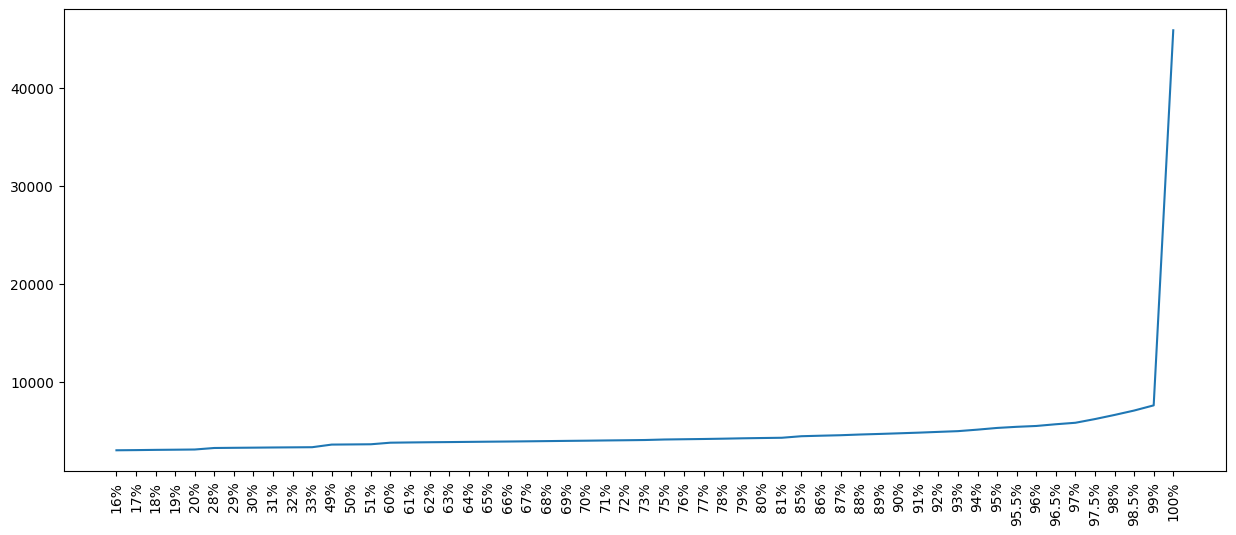

0
Brenner: 29505.08203125


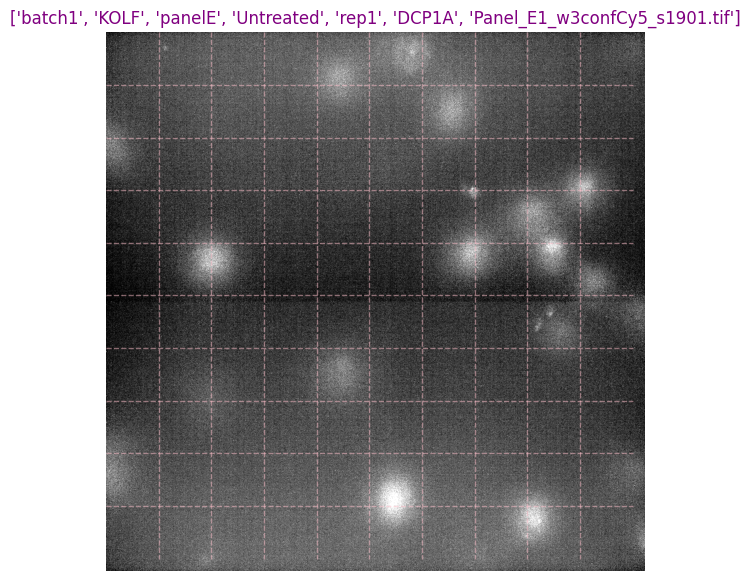

--------------------------------
1
Brenner: 8121.9931640625


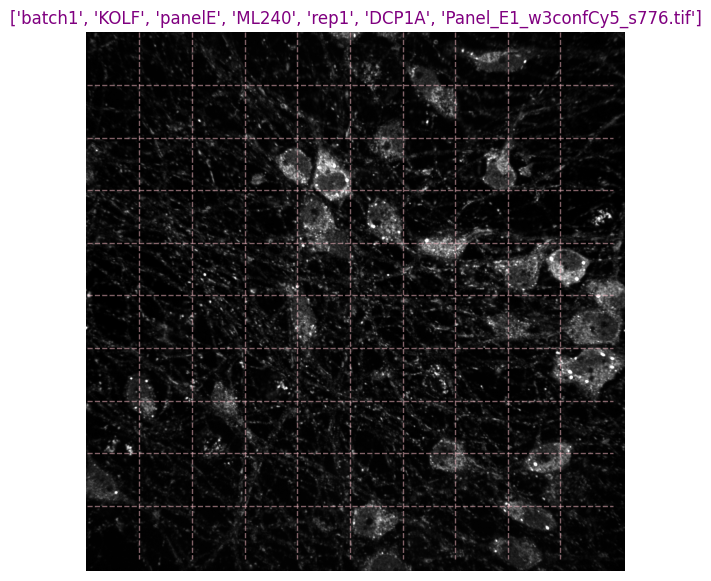

--------------------------------
2
Brenner: 9284.591796875


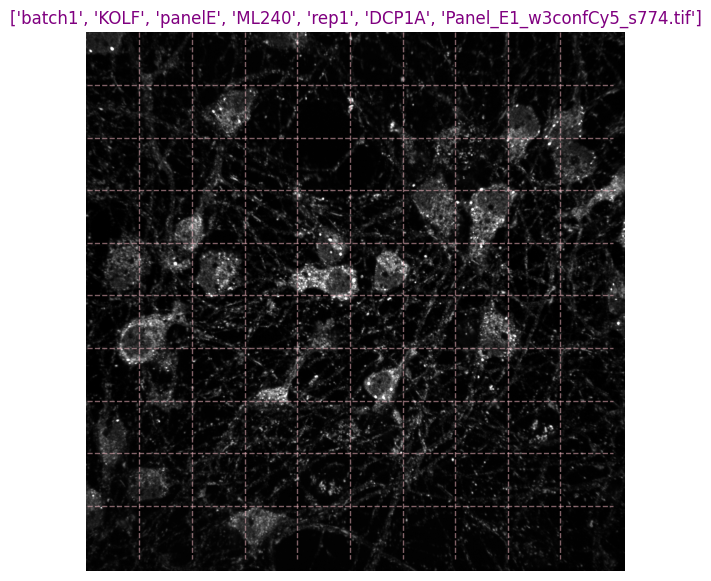

--------------------------------
3
Brenner: 8480.1826171875


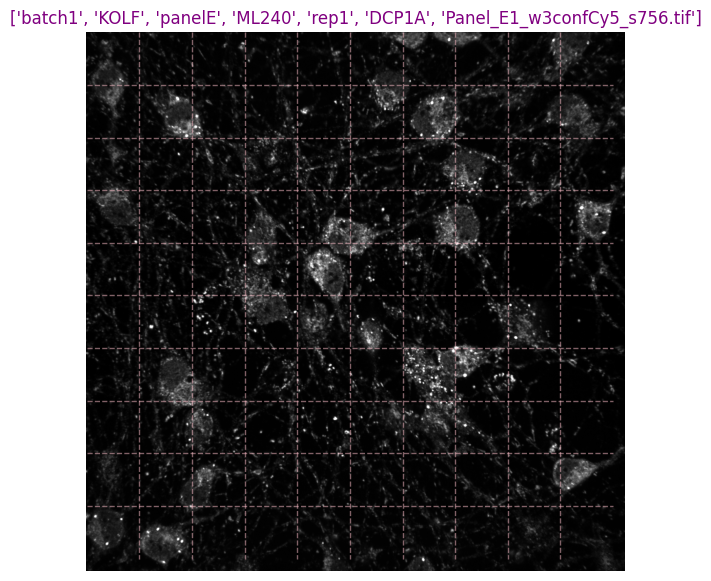

--------------------------------
4
Brenner: 7042.14404296875


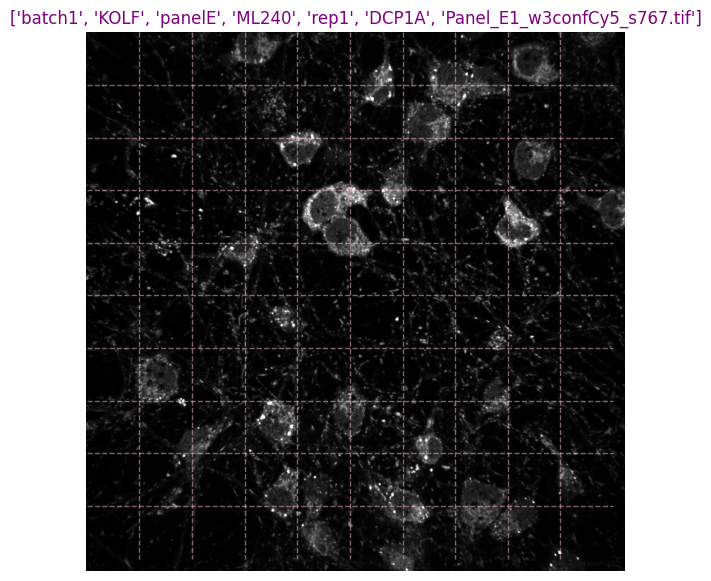

--------------------------------
5
Brenner: 8631.322265625


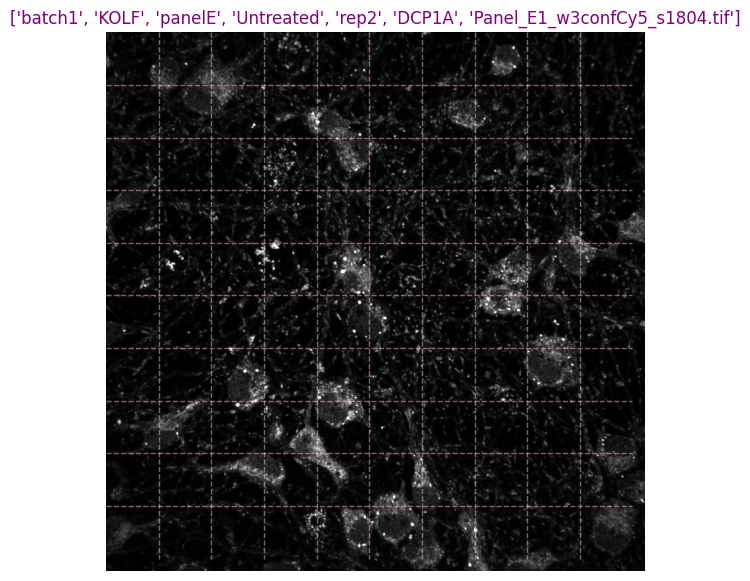

--------------------------------
6
Brenner: 8953.02734375


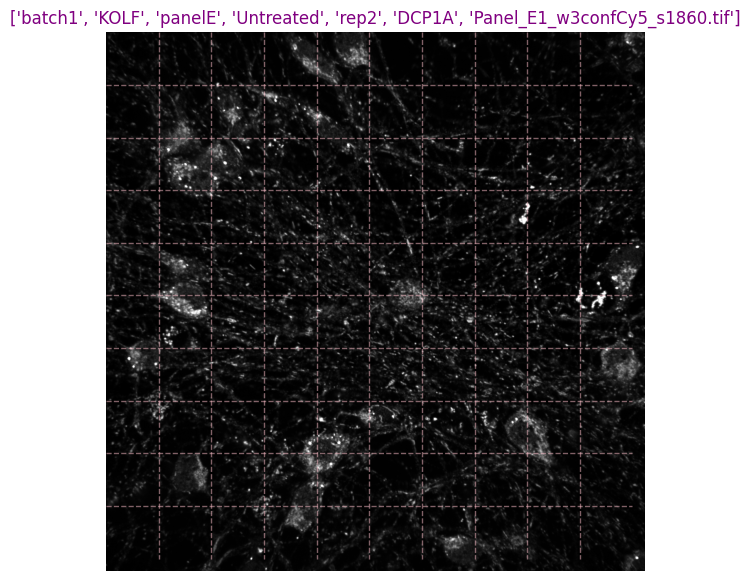

--------------------------------
7
Brenner: 7363.0361328125


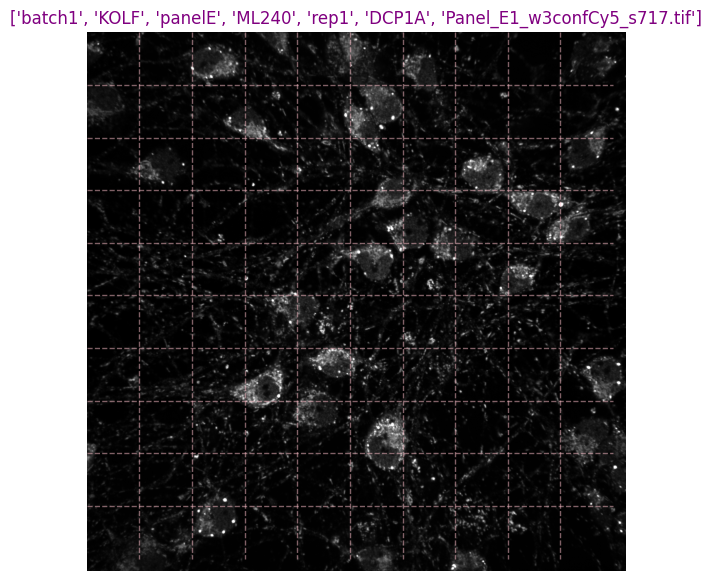

--------------------------------
8
Brenner: 7137.26220703125


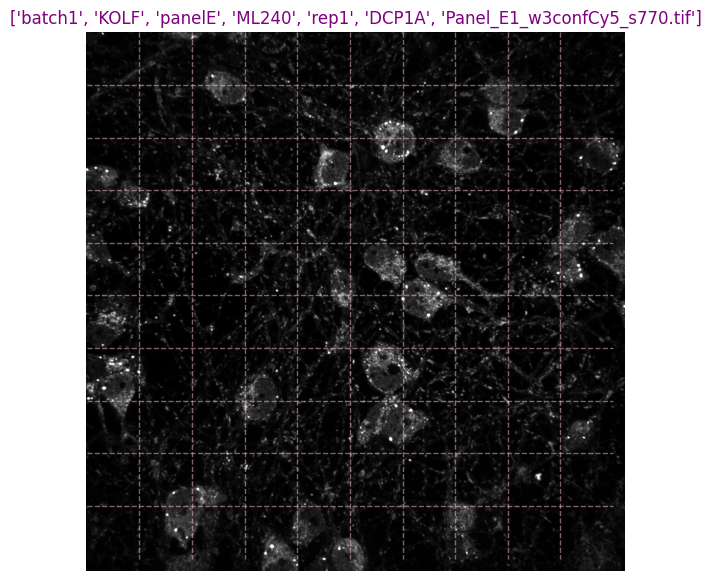

--------------------------------
9
Brenner: 9377.439453125


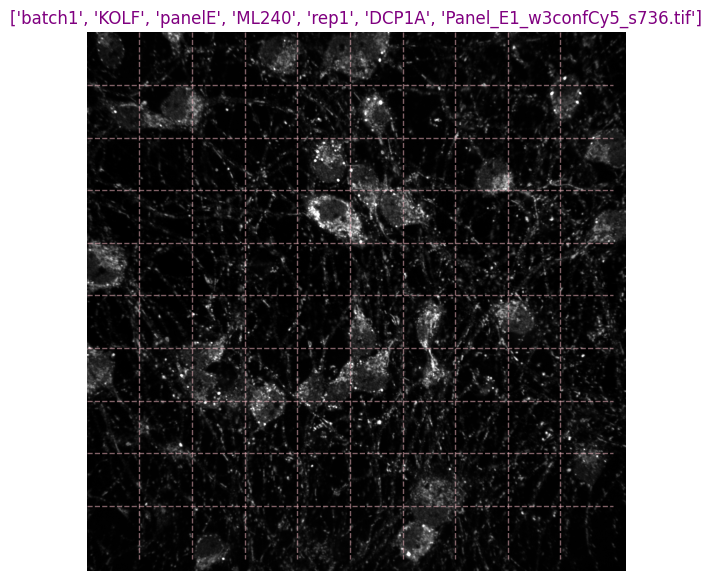

--------------------------------
10
Brenner: 7583.5078125


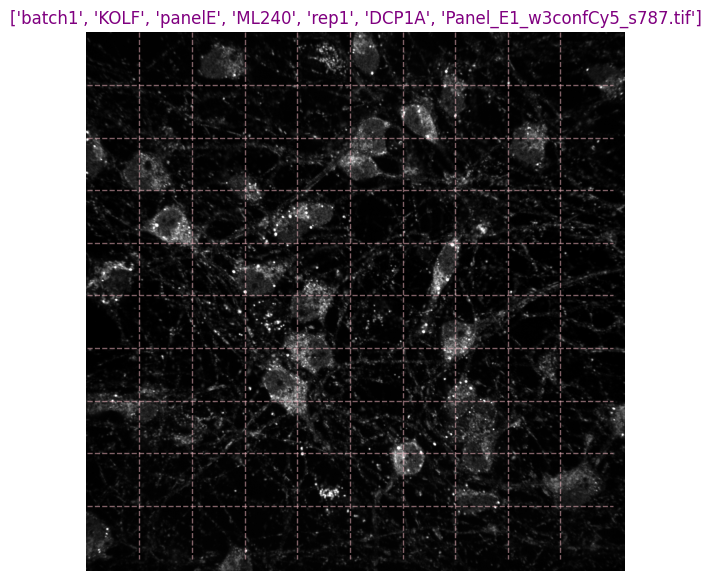

--------------------------------
11
Brenner: 7176.81689453125


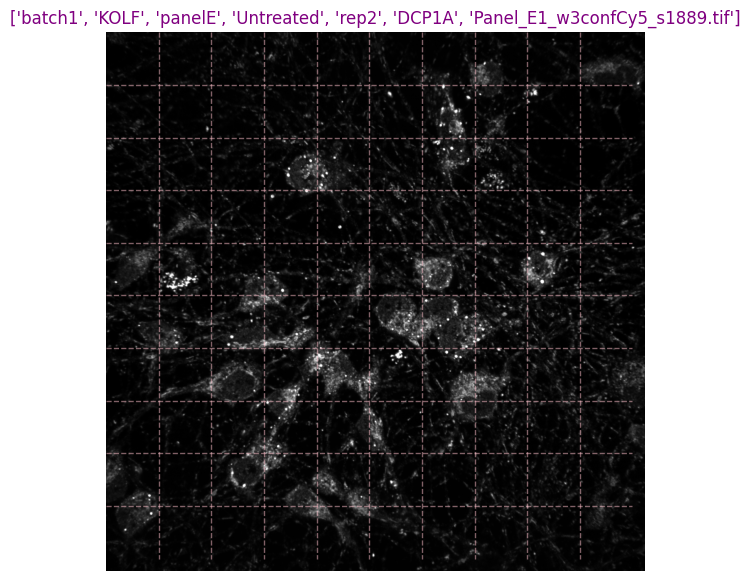

--------------------------------
12
Brenner: 19848.72265625


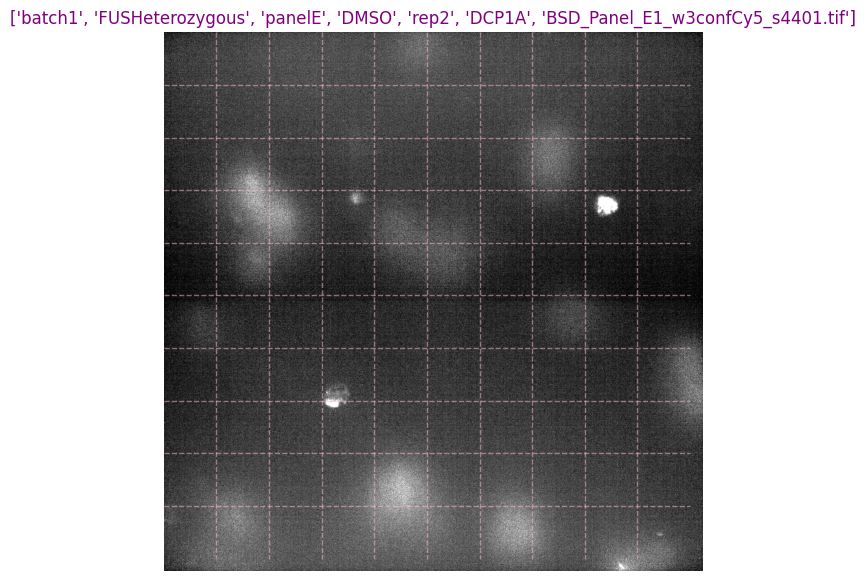

--------------------------------
13
Brenner: 6647.5419921875


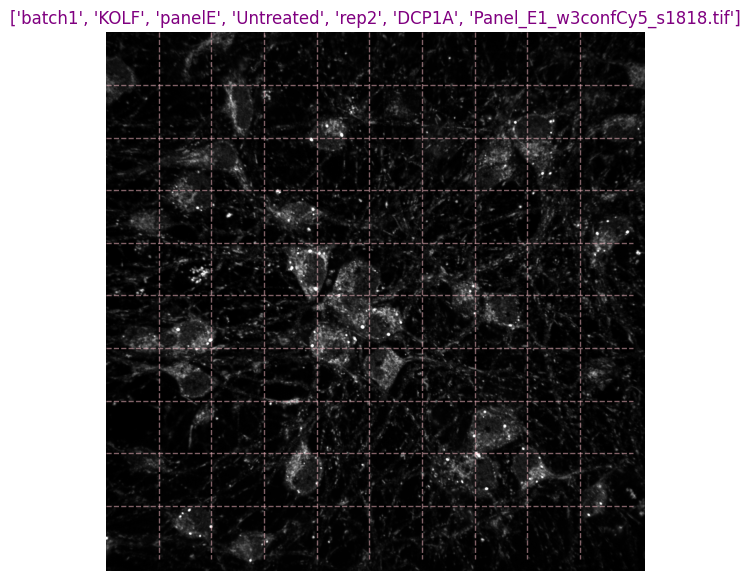

--------------------------------
14
Brenner: 7302.07177734375


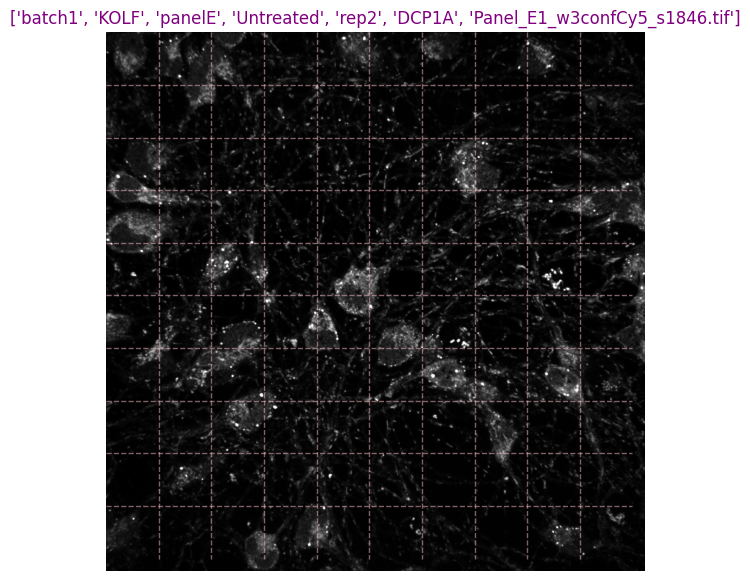

--------------------------------
15
Brenner: 6664.2021484375


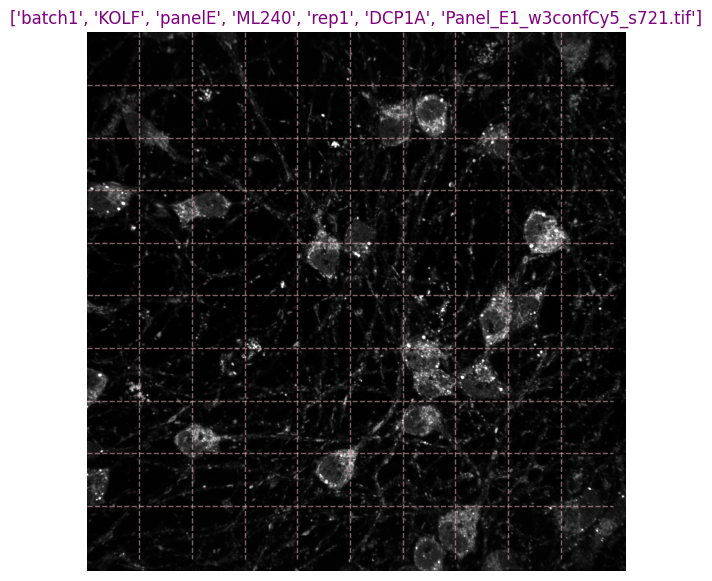

--------------------------------
16
Brenner: 6734.22607421875


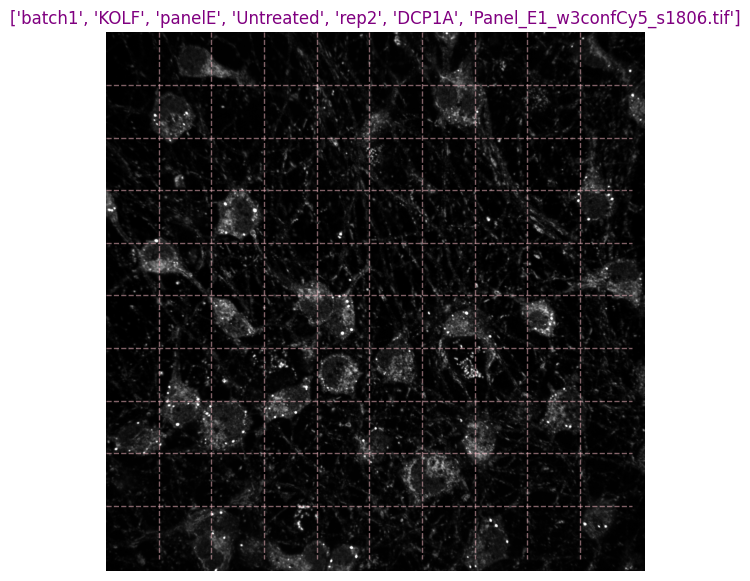

--------------------------------
17
Brenner: 7602.66796875


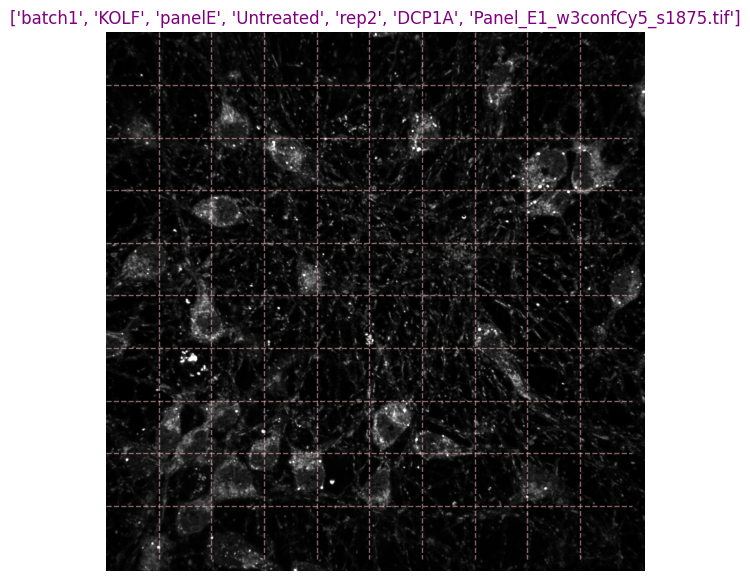

--------------------------------
18
Brenner: 13046.552734375


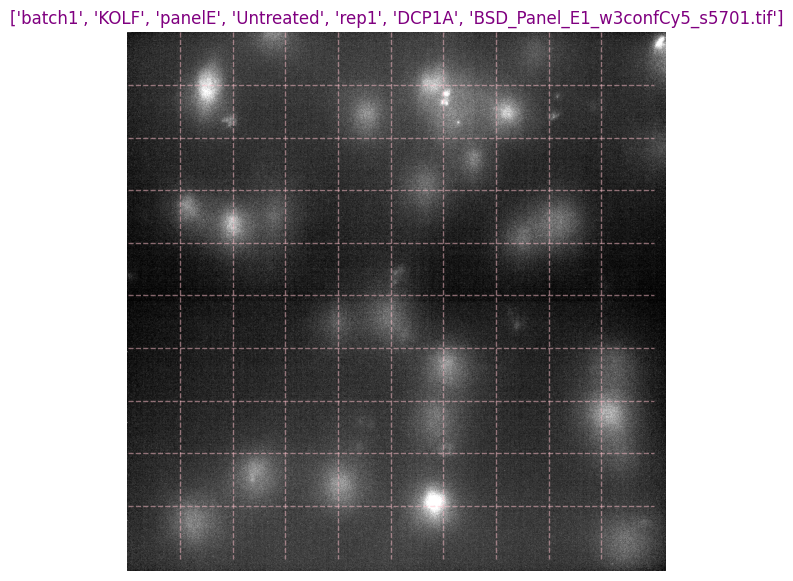

--------------------------------
19
Brenner: 7048.7919921875


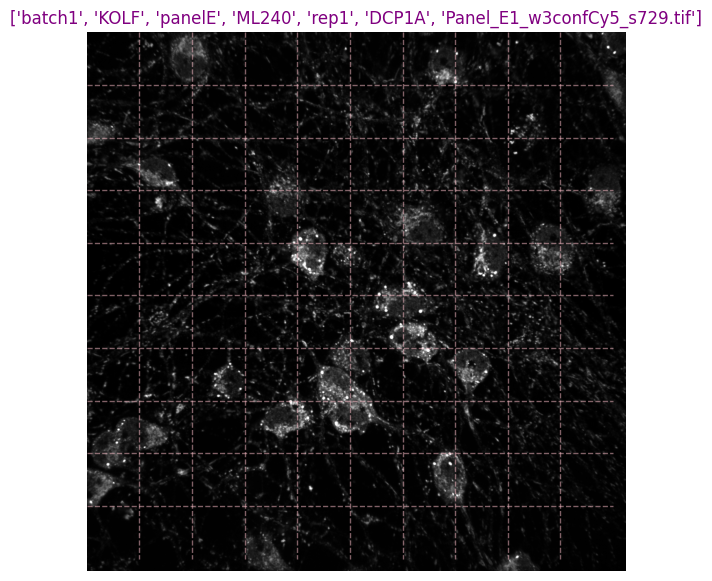

--------------------------------
20
Stopping at 20. There are 112 images in total
The thresholds map:


{'NEMO': {'Target_Sharpness_Brenner': {'low_threshold': 15491,
   'high_threshold': 28000}},
 'DCP1A': {'Target_Sharpness_Brenner': {'low_threshold': 3000,
   'high_threshold': 6624}},
 'SNCA': {'Target_Sharpness_Brenner': {'low_threshold': 2416.62392,
   'high_threshold': 23953}},
 'PSD95': {'Target_Sharpness_Brenner': {'low_threshold': 4000,
   'high_threshold': 25250.947062500003}},
 'CLTC': {'Target_Sharpness_Brenner': {'low_threshold': 1500,
   'high_threshold': 20000}},
 'FMRP': {'Target_Sharpness_Brenner': {'low_threshold': 653.570637,
   'high_threshold': 5743.8664499999995}},
 'SQSTM1': {'Target_Sharpness_Brenner': {'low_threshold': 1576.21625,
   'high_threshold': 10000}},
 'TDP43': {'Target_Sharpness_Brenner': {'low_threshold': 1500,
   'high_threshold': 14039}},
 'TOMM20': {'Target_Sharpness_Brenner': {'low_threshold': 3000,
   'high_threshold': 11825.144587499999}}}

In [83]:
import scipy

# percentiles_to_describe=[0,.003,0.005,0.01,0.02,0.03,0.04,0.05,.06,0.07,.08,.09,0.1,.11,.12,.13,.14,.15]
percentiles_to_describe=[.16,.17,.18,.19,.20,.28,.29,.3,.31,.32,.33,.49,.5,.51,.60,.61,.62,.63,.64,.65,.66,.67,.68,.69,.70,.71,.72,.73,.75,.76,.77,.78,.79,.80,.81,.85,.86,.87,.88,.89,.90,.91,.92,.93,.94,.95,.955,.96,.965,.97,.975, .98,.985,.99,1]
marker = 'DCP1A'
metric_name = 'Target_Sharpness_Brenner'
percentiles = df.loc[df['Marker']==marker, metric_name].describe(percentiles=percentiles_to_describe)


box_plot_percentile = df.loc[df['Marker']==marker, metric_name].describe(percentiles=[.25,.75])
boxplot_upper_bound = box_plot_percentile["75%"] + 1.5 * scipy.stats.iqr(df.loc[df['Marker']==marker, metric_name])
boxplot_lower_bound = box_plot_percentile["25%"] - 1.5 * scipy.stats.iqr(df.loc[df['Marker']==marker, metric_name])

print(f"boxplot_lower_bound = {boxplot_lower_bound}, boxplot_upper_bound = {boxplot_upper_bound},")

# low_threshold = table_data[marker][0]#percentiles[f'{per}%'] # for cellular debris
# high_threshold = table_data[marker][1] #15000#percentiles[f'{per}%'] # for out of focus

# low_threshold = boxplot_lower_bound
high_threshold = 6624#boxplot_upper_bound#30000#table_data[marker][1] #15000#percentiles[f'{per}%'] # for out of focus


# per = 1
# low_threshold = percentiles[f'{per}%'] # for cellular debris
# high_threshold = percentiles[f'{per}%']#table_data[marker][1] #15000#percentiles[f'{per}%'] # for out of focus


# per = "From Mapping"
# low_threshold = markers_dict[marker]['lower_bound'] # debris
# high_threshold = markers_dict[marker]['upper_bound'] # out of focus

max_samples = 20

print(marker, metric_name, low_threshold, high_threshold, f'({per}%)')
print()
print(marker, '\n', percentiles)


# c = (df[metric_name]<=low_threshold) #& (df[metric_name]>=percentiles[f'20%'])  
c = (df[metric_name]>=high_threshold) #& (df[metric_name]<=percentiles[f'{per+1}%'] ) #& (df[metric_name]<=25000) # & (df[metric_name]<=percentiles[f'{per+1}%'] )

# c = (df[metric_name]<=9771) & (df[metric_name]>=low_threshold)  
# c = (df[metric_name]>=high_threshold) & (df[metric_name]<=30000 ) #& (df[metric_name]<=25000) # & (df[metric_name]<=percentiles[f'{per+1}%'] )


tmp = df[c]
# print(tmp.shape)
tmp = tmp[(tmp.Marker==marker)]

tmp = tmp.sample(frac=1, random_state=1)

print(tmp.shape, round(tmp.shape[0] * 100.0/counts[marker], 3), 100-round(tmp.shape[0] * 100.0/counts[marker], 3))


plt.figure(figsize=(15,6))
plt.plot(percentiles.keys().to_numpy()[4:-1], percentiles.values[4:-1])
plt.xticks(rotation=90)
plt.show()

show_images(tmp, max_samples=max_samples)    

save_to_mapping(mappings, marker, metric_name, low_threshold, high_threshold)

print("The thresholds map:")
mappings
